Let's start with a pretrained VGG model

In [1]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import numpy as np
import cv2
from keras import backend as K

Using TensorFlow backend.


1.  Loading helper functions
2.  Load VGG
3. Load Image
4. Rescale image to 224x224x3 (VGG's expectation, why?)
5. Use expand_dims to convert image to a batch of size 1
6. Preprocesing normalizes our input image by subtracting mean RGB values

In [2]:
!pip install Pillow
model = VGG16(weights="imagenet")
from skimage import io
from PIL import Image
import requests
url = 'https://media.karousell.com/media/photos/products/2018/08/20/16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg'
img = Image.open(requests.get(url, stream=True).raw)
hero = np.array(img)
hero = cv2.resize(hero, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
x = image.img_to_array(hero)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

W0709 04:37:19.510766 140028779059072 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0709 04:37:19.527756 140028779059072 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0709 04:37:19.531818 140028779059072 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0709 04:37:19.564744 140028779059072 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0709 04:37:21.444953 140028779059072 deprecation_wrapp

1. We get the predictions for the image
2. We take the topmost class index
3. Take output from the final convolutional layer

In [3]:
#for layer in model.layers:
#    print(layer.name)
preds = model.predict(x)
#class_idx = np.argmax(preds[0])
class_idx = 836
print(class_idx)
class_output = model.output[:, class_idx]
#last_conv_layer = model.get_layer("block5_conv3")
last_conv_layer = model.get_layer("block5_conv2")

836


1. Compute the gradient of the class output value with respect to the feature map
2. Pool the gradients over all the axies leaving out the channel dimension
3. Weigh the output feature map with the computed gradient values

In [4]:
grads = K.gradients(class_output, last_conv_layer.output)[0]
print(grads.shape)
pooled_grads = K.mean(grads, axis=(0, 1, 2))
print(pooled_grads.shape)
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
  conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

(?, 14, 14, 512)
(512,)


1. Average the weighted feature map along the channel dimension resulting in a heat map of size 14x14 
2. Normalize the heat map to make the values between 0 and 1

In [5]:
heatmap = np.mean(conv_layer_output_value, axis = -1)
print(conv_layer_output_value.shape)
print(heatmap.shape)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

(14, 14, 512)
(14, 14)


Show the results

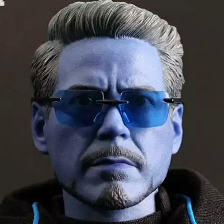

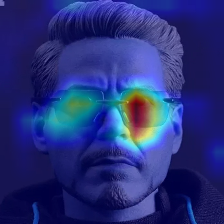

In [6]:
heatmap = cv2.resize(heatmap, (hero.shape[1], hero.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(hero, 0.5, heatmap, 0.5, 0)
from google.colab.patches import cv2_imshow
cv2_imshow( hero)
cv2_imshow(superimposed_img)